In [1]:
! gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?code_challenge=u4hUgx201rV9eFbko9roAWoSB8il9aMSYuFXfGzeQhI&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


If you need to use ADC, see:
  gcloud auth application-default --help

You are now logged in as [galli.giuly@gmail.com].
Your current project is [reddit-master].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [2]:
!gcloud config set project reddit-master

Updated property [core/project].


In [12]:
!gsutil ls gs://reddit_final_results/

gs://reddit_final_results/comments_posts_2018.csv
gs://reddit_final_results/comments_posts_2018.zip
gs://reddit_final_results/comments_posts_2018_V2.csv
gs://reddit_final_results/comments_posts_2018_V2.zip
gs://reddit_final_results/comments_posts_Fitness.pkl
gs://reddit_final_results/comments_posts_IAmA.pkl
gs://reddit_final_results/comments_posts_atheism.pkl
gs://reddit_final_results/comments_posts_aww.pkl
gs://reddit_final_results/comments_posts_europe.pkl
gs://reddit_final_results/comments_posts_funny.pkl
gs://reddit_final_results/comments_posts_gaming.pkl
gs://reddit_final_results/comments_posts_movies.pkl
gs://reddit_final_results/comments_posts_nba.pkl
gs://reddit_final_results/comments_posts_politics.pkl
gs://reddit_final_results/comments_posts_science.pkl
gs://reddit_final_results/comments_posts_technology.pkl
gs://reddit_final_results/comments_posts_todayilearned.pkl
gs://reddit_final_results/comments_posts_tokenized.csv
gs://reddit_final_results/comments_posts_tokenized.zip
g

In [5]:
!gsutil cp gs://reddit_final_results/red_comments_posts.csv .

Copying gs://reddit_final_results/red_comments_posts.csv...
Resuming download for ./red_comments_posts.csv component 0                      
Resuming download for ./red_comments_posts.csv component 1
Resuming download for ./red_comments_posts.csv component 2
- [1 files][561.1 MiB/561.1 MiB]    2.1 MiB/s                                   
Operation completed over 1 objects/561.1 MiB.                                    


In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
import logging
import nltk
nltk.download('stopwords')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
from IPython.core.interactiveshell import InteractiveShell
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [3]:
logger = logging.getLogger('lstm-keras')
logger.setLevel(logging.DEBUG)

In [6]:
subreddits = ['aww', 'nba', 'movies', 'todayilearned', 'IAmA', 'Fitness', 'worldnews', 'technology', 'europe', 'politics', 'atheism','science', 'funny', 'gaming']

model_LSTM_df = pd.read_csv('red_comments_posts.csv', index_col=[0])

/nix/store/94jxlqmlr777cnw3wa9ycx6651hdpzg5-python3.7-ipython-7.8.0/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



In [7]:
model_LSTM_df.head()

,subreddit,body
0,funny,Did a hell of a job with the blue duck then if...
1,funny,And the ones who don't will settle because at ...
2,funny,My grand father fished cods like this 50 years...
3,funny,It’s fake yes but how did they do it? The eff...
4,funny,They should have smoke bombs that have bug poi...


In [8]:
model_LSTM_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2164603 entries, 0 to 2164568
Data columns (total 2 columns):
subreddit    object
body         object
dtypes: object(2)
memory usage: 49.5+ MB


In [9]:
model_LSTM_df.subreddit.value_counts()

funny            155224
gaming           155224
atheism          155224
Fitness          155224
IAmA             155224
europe           155224
nba              155224
movies           155224
politics         154188
technology       153880
science          153750
worldnews        153659
aww              153656
todayilearned    153644
Name: subreddit, dtype: int64

In [10]:
model_LSTM_df['subreddit'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='number of posts', 
                                                                title='posts and comments per subreddit')

In [11]:
model_LSTM_df.isna().sum()
model_LSTM_df = model_LSTM_df.dropna()
model_LSTM_df.isna().sum()

subreddit    34
body         34
dtype: int64

subreddit    0
body         0
dtype: int64

In [12]:
# trying a new way for cleaning my text

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # symbols 
    text = BAD_SYMBOLS_RE.sub('', text) # keeping only basic text 
    # tring to remove double white spaces...
    #    text = re.sub(r'\W+', '', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # stopwors
    return text

model_LSTM_df['body'] = model_LSTM_df['body'].dropna()
model_LSTM_df['body'] = model_LSTM_df['body'].apply(clean_text)

In [13]:
model_LSTM_df.head()

,subreddit,body
0,funny,hell job blue duck top photo source
1,funny,ones dont settle least something
2,funny,grand father fished cods like 50 years ago
3,funny,fake yes effect real
4,funny,smoke bombs bug poison combined


In [14]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 450
EMBEDDING_DIM = 100

In [15]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS,)
tokenizer.fit_on_texts(model_LSTM_df['body'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1099338 unique tokens.


In [16]:
X = tokenizer.texts_to_sequences(model_LSTM_df['body'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2164569, 450)


In [17]:
Y = pd.get_dummies(model_LSTM_df['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2164569, 14)


In [18]:
def train_dev_test_split(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)
    return (X_train,
                X_val,
                X_test,
                y_train,
                y_val,
                y_test)


X_train, X_val, X_test, Y_train, Y_val, Y_test = train_dev_test_split(X,Y)

print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(1515198, 450) (1515198, 14)
(324685, 450) (324685, 14)
(324686, 450) (324686, 14)


# Approaching LSTM

I'll using a LSTM of 30 units, 5 epochs, and a batch size of 512

In [19]:
# Creating the neural network using Keras' functional api so that
# I'm able to inspect each one of the layers later.

inpt = Input(shape=(MAX_SEQUENCE_LENGTH,)) 
emb = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])(inpt)
dropout = SpatialDropout1D(0.2)(emb)
lstm = LSTM(30, dropout=0.2, recurrent_dropout=0.2)(dropout)
output = Dense(14, activation='softmax')(lstm)
model = Model(inputs =[inpt], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 450)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 450, 100)          7500000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 450, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dense_1 (Dense)              (None, 14)                434       
Total params: 7,516,154
Trainable params: 7,516,154
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
epochs = 10
batch_size = 150
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1, 
    min_delta=0.01)

history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping])

Train on 1515198 samples, validate on 324685 samples
Epoch 1/10
1515198/1515198 [==============================] - 3087s 2ms/step - loss: 1.6174 - accuracy: 0.4886 - val_loss: 1.4718 - val_accuracy: 0.5348
Epoch 2/10
1515198/1515198 [==============================] - 3172s 2ms/step - loss: 1.4257 - accuracy: 0.5485 - val_loss: 1.4459 - val_accuracy: 0.5432
Epoch 3/10
1515198/1515198 [==============================] - 3082s 2ms/step - loss: 1.3672 - accuracy: 0.5654 - val_loss: 1.4463 - val_accuracy: 0.5443


In [21]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

324686/324686 [==============================] - 270s 832us/step
Test set
  Loss: 1.444
  Accuracy: 0.544


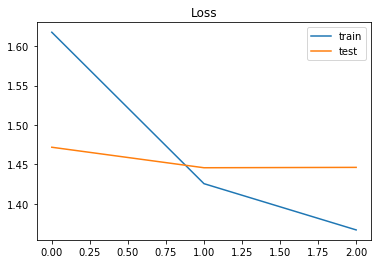

In [22]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

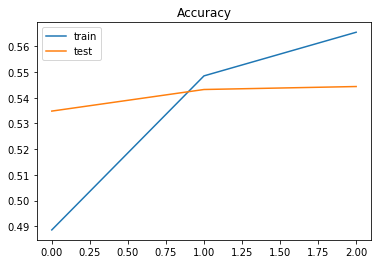

In [23]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [24]:
model.save('red_model_lstm_30_batchsize_512_v2.h5')

In [25]:
!gsutil cp red_model_lstm_30_batchsize_512_v2.h5 gs://reddit_models

Copying file://red_model_lstm_30_batchsize_512_v2.h5 [Content-Type=application/octet-stream]...
- [1 files][ 86.0 MiB/ 86.0 MiB]    4.3 MiB/s                                   
Operation completed over 1 objects/86.0 MiB.                                     


In [26]:
import keras
model = keras.models.load_model('red_model_lstm_30_batchsize_512_v2.h5')

# mapping subreddit to one hot encoding of subreddit
oho_mapping = {}

oho = pd.get_dummies(model_LSTM_df['subreddit'])

for subreddit in subreddits:
    oho_mapping[subreddit] = oho[oho[subreddit] == 1].iloc[0].values

MAX_SEQUENCE_LENGTH = 450    
NUMBER_OF_TEXTS = 10000

for subreddit in subreddits:
    df = model_LSTM_df[model_LSTM_df['subreddit'] == subreddit]
    Y = np.matrix([oho_mapping[subreddit] for i in range(0, NUMBER_OF_TEXTS)])
    X = pad_sequences(tokenizer.texts_to_sequences(df['body'].sample(NUMBER_OF_TEXTS).values), maxlen=MAX_SEQUENCE_LENGTH)
    accr = model.evaluate(X,Y)
    print("training " + subreddit)
    print(accr)

10000/10000 [==============================] - 8s 831us/step
training aww
[1.0715669664382934, 0.6919999718666077]
10000/10000 [==============================] - 8s 823us/step
training nba
[0.6563854746818543, 0.8277999758720398]
10000/10000 [==============================] - 8s 827us/step
training movies
[1.073664287185669, 0.7005000114440918]
10000/10000 [==============================] - 8s 818us/step
training todayilearned
[2.0228279468536376, 0.27410000562667847]
10000/10000 [==============================] - 8s 826us/step
training IAmA
[1.6678224349975586, 0.43540000915527344]
10000/10000 [==============================] - 8s 825us/step
training Fitness
[0.474894340801239, 0.8784000277519226]
10000/10000 [==============================] - 8s 829us/step
training worldnews
[1.707959684753418, 0.35600000619888306]
10000/10000 [==============================] - 8s 831us/step
training technology
[1.317725009727478, 0.5881999731063843]
10000/10000 [==============================] - 8s 

# Visualization

<BarContainer object of 14 artists>

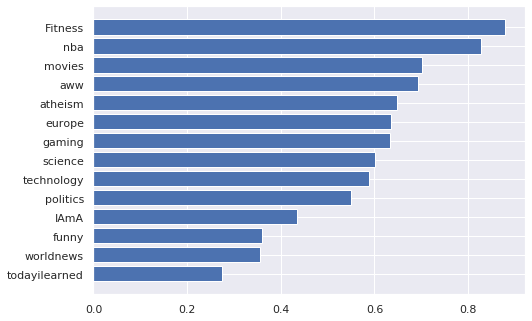

In [5]:
import collections

subreddits = {
    "aww": 0.6919999718666077,
    "nba": 0.8277999758720398,
    "movies": 0.7005000114440918,
    "todayilearned": 0.27410000562667847,
    "IAmA": 0.43540000915527344,
    "Fitness": 0.8784000277519226,
    "worldnews": 0.35600000619888306,
    "technology": 0.5881999731063843,
    "europe": 0.635699987411499,
    "politics": 0.5497000217437744,
    "atheism": 0.6481999754905701,
    "science": 0.6011000275611877,
    "funny": 0.35920000076293945,
    "gaming": 0.633899986743927
}

sort = collections.OrderedDict(sorted(subreddits.items(), key=lambda kv: kv[1]))

figure = plt.figure()
ax = figure.add_axes([0,0,1,1])

ax.barh(list(sort.keys()), list(sort.values()))
plt.show()